In [395]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [396]:
NSAMPLES = 4096
sample_fq0 = 20 # MHz
#sample_fq1 = 20.1 # MHz
sample_fq1 = 19.9 # MHz

TONE = 8.7 # MHz
V0 = np.cos(2*np.pi*TONE * np.arange(NSAMPLES) / sample_fq0).astype(np.float32)
V1 = np.cos(2*np.pi*TONE * np.arange(NSAMPLES) / sample_fq1).astype(np.float32)

<IPython.core.display.Javascript object>


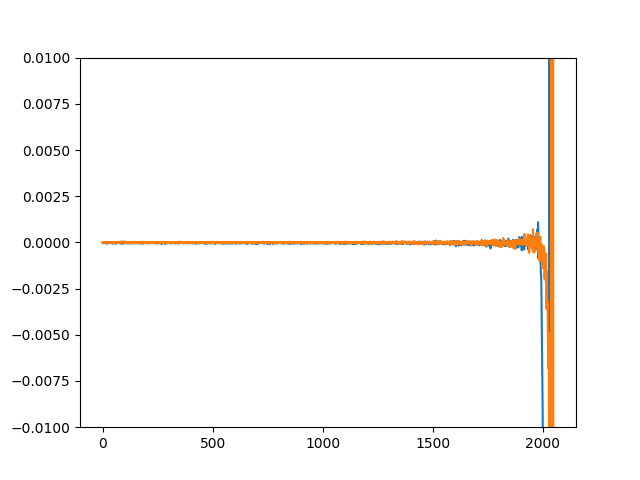

(-0.01, 0.01)

In [397]:
NBLOCKS = 400
_noise = np.random.normal(size=(NBLOCKS, NSAMPLES//2 + 1)) + 1j * np.random.normal(size=(NBLOCKS, NSAMPLES//2 + 1))
_noise[..., -20:] = 0
fqs = np.fft.rfftfreq(NSAMPLES)
t0s = np.arange(NSAMPLES)
t1s = sample_fq0/sample_fq1 * np.arange(NSAMPLES)
n0 = np.einsum('tf,bf->bt', np.exp(2j*np.pi*np.outer(t0s, fqs)), _noise).real
n1 = np.einsum('tf,bf->bt', np.exp(2j*np.pi*np.outer(t1s, fqs)), _noise).real
n2 = np.array([resample(_n, sample_fq1, sample_fq0) for _n in n1])
_n0 = np.fft.rfft(n0)
ans = np.mean(_n0 * np.fft.rfft(n2).conj(), axis=0) / np.mean(_n0 * _n0.conj(), axis=0)

plt.figure()
plt.plot(np.abs(ans) - 1)
plt.plot(np.angle(ans))
plt.ylim(-0.01, 0.01)
#plt.plot(t0s, n0)
#plt.plot(t1s, n1 - n0)
#plt.plot(t0s, n0 - n2)

<IPython.core.display.Javascript object>


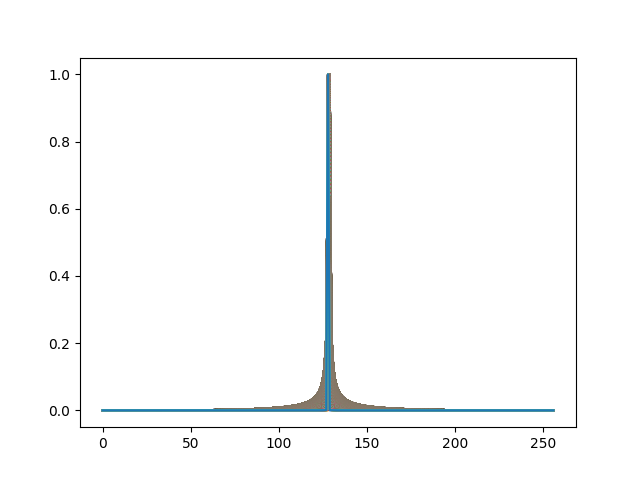

In [436]:
plt.figure()
_ = plt.plot(np.abs(_cache['nuttall', 128]))

In [458]:
from scipy.signal import get_window

RES = 0.001
DTYPE = np.float32
ndt = np.concatenate([np.array([0], dtype=DTYPE), np.arange(1, 0, -RES, dtype=DTYPE)])

_cache = {}

def _clear_cache():
    global _cache
    _cache = {}
    
def _cache_filter(window, half_width, dtype):
    key = (window, half_width)
    if not key in _cache:
        x = np.arange(-half_width, half_width+1, dtype=dtype)
        win = get_window(window, 2*half_width+1).astype(dtype)
        sinc = win[:,None] * np.sinc(x[:,None] - ndt[None,:])
        _cache[key] = sinc
    return _cache[key]
    
def _cache_ker(nsamples, f_in, f_out, dt0, window, half_width, dtype):
    key = (nsamples, f_in, f_out, dt0, window, half_width)
    if not key in _cache:
        x = np.arange(-half_width, half_width+1, dtype=int)
        i = np.arange(nsamples, dtype=int)
        dt = 1 - f_in / f_out
        dt = np.arange(dt0, dt0+nsamples*dt, dt, dtype=dtype)
        off = np.ceil(dt).astype(int)
        dt -= off
        i -= off
        inds = (x[:,None] + i[None,:]).clip(0, nsamples-1)
        sinc = _cache_filter(window, half_width, dtype)
        ker = sinc[:, np.around(dt / RES).astype(int)]
        _cache[key] = inds, ker
    return _cache[key]

def resample(sig_in, f_in, f_out, dt0=0, window='nuttall', half_width=128, dtype=np.float32):
    inds, ker = _cache_ker(sig_in.shape[0], f_in, f_out, dt0, window, half_width, dtype)
    #ker[inds < 0] = 0  # boundary is messed up anyway
    #ker[inds >= nsamples] = 0  # boundary is messed up anyway
    return np.einsum('ij,ij->j', sig_in[inds], ker)
    #return np.sum(sig_in[inds] * ker, axis=0)  # just slightly slower than einsum

In [351]:
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [459]:
V2 = resample(V1, sample_fq1, sample_fq0)

In [460]:
%%timeit
#%%snakeviz
V2 = resample(V1, sample_fq1, sample_fq0)

10.9 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


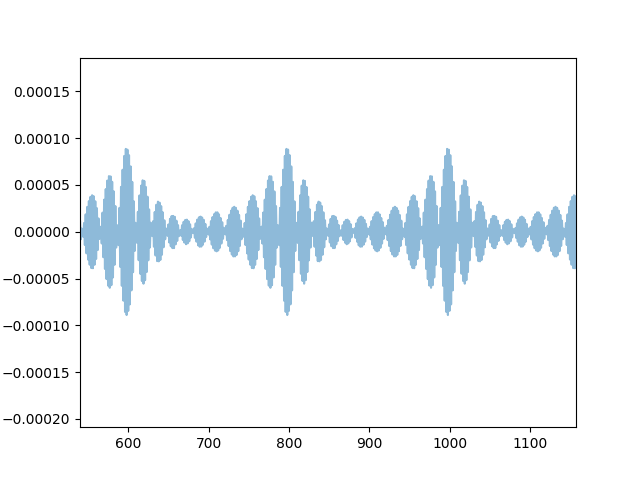

(-0.001, 0.001)

In [427]:
plt.figure()
_clear_cache()
TONE = 9.5 # MHz
V0 = np.cos(2*np.pi*TONE * np.arange(NSAMPLES) / sample_fq0).astype(np.float32)
V1 = np.cos(2*np.pi*TONE * np.arange(NSAMPLES) / sample_fq1).astype(np.float32)
V2a = resample(V1, sample_fq1, sample_fq0, window='nuttall')
#V2b = resample(V1, sample_fq1, sample_fq0, window='blackmanharris')
plt.plot(V2a - V0, alpha=0.5)
#plt.plot(V2b - V0, alpha=0.5)
plt.ylim(-1e-3,1e-3)

In [441]:

#window_name = ['nuttall', 'hamming', 'blackmanharris']
window_name = ['nuttall']
tones = np.linspace(0, sample_fq0/2, 101, endpoint=False)
#tones = [TONE]

rms = {}

for hw in (32, 64, 96, 128, 256):
#for hw in (128,):
    for tone in tones:
        V0 = np.cos(2*np.pi*tone * np.arange(NSAMPLES) / sample_fq0)
        V1 = np.cos(2*np.pi*tone * np.arange(NSAMPLES) / sample_fq1)
        V2 = {name: resample(V1, sample_fq1, sample_fq0, half_width=hw, window=name) for name in window_name}
        #off = 0
        #for i in range(NSAMPLES):
        #    if i * dt >= off + 1:
        #        off += 1
        #    elif i * dt <= off - 1:
        #        off -= 1
        #    i -= off
        #    if i >= NSAMPLES:
        #        for name, win in window.items():
        #            V1_0[name] = V1_0.get(name, []) + [0]
        #        continue
        #    i0 = min(i, hw)
        #    i1 = min(NSAMPLES - i, hw + 1)
        #    _x = x[hw-i0:hw+i1] + (i+off)*dt - off
        #    k = np.sinc(_x)
        #    for name, win in window.items():
        #        ker = k * win[hw-i0:hw+i1]
        #        try:kers[name] = kers.get(name, []) + [k * win]
        #        except: pass
        #        V1_0[name] = V1_0.get(name, []) + [np.sum(V1[i-i0:i+i1] * ker)]
        for name, data in V2.items():
            rms[hw, name] = rms.get((hw, name), []) + [np.std((np.array(data) - V0)[256:-256])]

<IPython.core.display.Javascript object>


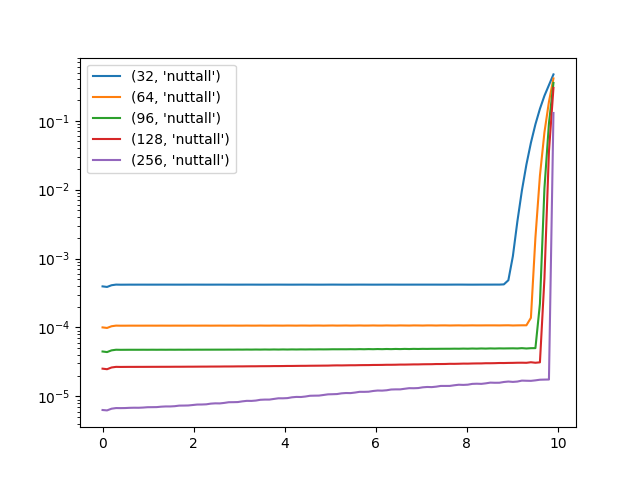

In [442]:
plt.figure()
for name, data in rms.items():
    plt.semilogy(tones, data, label=name)
plt.legend()

<IPython.core.display.Javascript object>


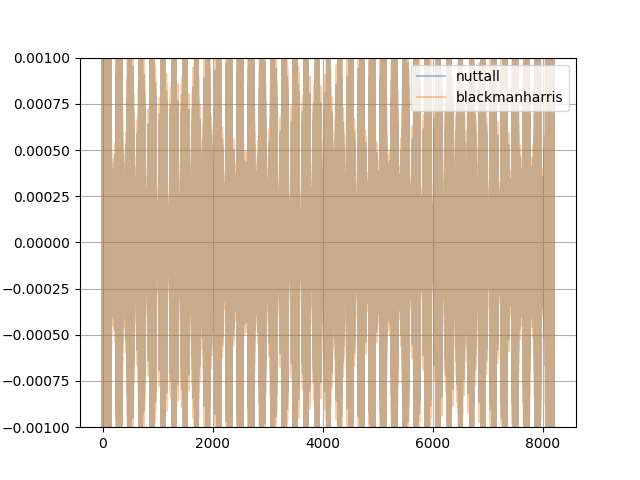

In [348]:
plt.figure()
for name, data in V1_0.items():
    plt.plot(data - V0, label=name, alpha=0.4)
plt.legend()
#plt.plot(V1_0 - V0, alpha=0.5)
#plt.plot(V1_1 - V0, alpha=0.5)
plt.ylim(-0.001, 0.001)
plt.grid()